In [38]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

font = {
    "family": "Times New Roman",
    'size': 18
}

matplotlib.rc('font', **font)

df = pd.read_csv('../data/worker.csv')
df.head()

,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES
0,28613,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-master-0,master,8bd29cd3a6c570901c5ce23aa0a5557266068fc370e1e4188f056b2fdae24944,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/gpu"": ""8"", ""ephemeral-storage"": ""4800Gi"", ""koordinator.sh/rdma"": ""1""}"
1,28614,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-0,worker,46547b40034dea27dff7a94dee665d3804b7869286d00dcf3508b9a98b4d9bd3,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/gpu"": ""8"", ""ephemeral-storage"": ""4800Gi"", ""koordinator.sh/rdma"": ""1""}"
2,28615,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-1,worker,47b54b963095fc8211922de281e8a1306783c9809d8ca634a44a9004ccc788b9,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/gpu"": ""8"", ""ephemeral-storage"": ""4800Gi"", ""koordinator.sh/rdma"": ""1""}"
3,28616,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-2,worker,7acd990b9db2ffb8b982727c3463746e7c25e0f215c28f82f0f55a49ed0ab793,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/gpu"": ""8"", ""ephemeral-storage"": ""4800Gi"", ""koordinator.sh/rdma"": ""1""}"
4,28617,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-3,worker,2d1f3f74639b00279140135610e4d4cce920754951735fbdba524f6b1b94a5d5,2023/7/15 00:47,NaN,2023/7/15 00:49,"{""cpu"": ""96"", ""memory"": ""1600Gi"", ""nvidia.com/gpu"": ""8"", ""ephemeral-storage"": ""4800Gi"", ""koordinator.sh/rdma"": ""1""}"


In [39]:
from util.parse_worker import df_worker_valid, df_worker_GPU, df_worker_jobs

df_worker_jobs

,job_name,start_time,end_time,num_gpus,duration
0,dlcar6cqs8mecvlz,0.032639,0.034028,48.0,0.001389
1,dlc1l3ajnoq4jyuw,0.034722,0.044444,48.0,0.009722
2,dlcqbbpj8g3txdux,0.093056,0.095139,48.0,0.002083
3,dlc1bei96sdtujoa,0.096528,0.098611,48.0,0.002083
4,dlc1v3pfd0c8wgui,0.097222,0.099306,16.0,0.002083
...,...,...,...,...,...
2708,dlc12dbwg4oy1322,15.604167,15.737500,8.0,0.133333
2709,dlc3z73t0uiiii2u,15.638194,16.091667,56.0,0.453472
2710,dlcxy69z8xv3kgua,15.654861,20.259028,32.0,4.604167
2711,dlc14pos90tl1xgs,15.943056,15.951389,48.0,0.008333


In [40]:
df = pd.read_csv("../data/topo.csv")
edges = set()
for _, row in df.iterrows():
    edges.add((row['ip'], row['ASW']))
    edges.add((row['ASW'], row['PSW']))
    edges.add((row['PSW'], row['DSW']))
import networkx as nx
graph = nx.from_edgelist(list(edges))


In [41]:
ip_index_dict = {k: i for i, k in enumerate(df['ip'])}
rack_index = {k: i for i, k in enumerate(df['ASW'].unique())}
import numpy as np
ip_to_rack_matrix = np.zeros((len(ip_index_dict), len(rack_index)), dtype=bool)

for _, row in df.iterrows():
    ip = ip_index_dict[row['ip']]
    rack = rack_index[row['ASW']]
    ip_to_rack_matrix[ip, rack] = 1
    
ip_to_rack_matrix


array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [42]:
def get_job_tm(job_name):
    list_host_ip = df_worker_GPU[df_worker_GPU['job_name'] == job_name]['host_ip']
    num_hosts = len(list_host_ip)

    # assume all-to-all traffic matrix
    tm_host_level = np.ones((num_hosts, num_hosts), dtype=int) - np.diag([1] * num_hosts)
    
    ip_index = [ip_index_dict[i] for i in list_host_ip]
    transform_matrix = ip_to_rack_matrix[ip_index]
    tm_rack_level = transform_matrix.T @ tm_host_level @ transform_matrix
    
    # ignore intra-rack traffic
    np.fill_diagonal(tm_rack_level, 0)
    rack_usage = np.any(tm_rack_level, axis=0)
    
    return rack_usage


In [46]:
from collections import OrderedDict

def count_jobs_at_each_moment():
    events = []

    for _, row in df_worker_jobs.iterrows():
        events.append((row['start_time'], 'start', row['job_name']))
        events.append((row['end_time'], 'end', row['job_name']))

    # Sort events by time, processing end before start at the same time
    events.sort(key=lambda x: (x[0], x[1] == 'start'))

    # Counting jobs over time
    active_jobs = set() 
    results = OrderedDict()
    for time, t, job_name in events:
        if t == 'start':
            active_jobs.add(job_name)
        else:
            active_jobs.remove(job_name)
        results[time] = active_jobs.copy()
    
    return results

active_jobs = count_jobs_at_each_moment()
list_timestamp = []
list_num_contention_jobs = []
list_max_rack_usage = []
contention_jobs = set()

for timestamp, jobs in active_jobs.items():
    list_rack_usage = []
    for job in jobs:
        list_rack_usage.append((job, get_job_tm(job)))
    rack_usage = sum([v for _, v in list_rack_usage])

    num_contention_jobs = 0
    if np.max(contention_rack := rack_usage >= 2) > 0:
        for job, r in list_rack_usage:
            if np.any(np.bitwise_and(r, contention_rack)):
                contention_jobs.add(job)
                num_contention_jobs += 1
    max_rack_usage = np.max(rack_usage)
    list_timestamp.append(timestamp)
    list_num_contention_jobs.append(num_contention_jobs)
    list_max_rack_usage.append(max_rack_usage)
    

df_runtime = pd.DataFrame({
    "timestamp": list_timestamp,
    "num_contention_jobs": list_num_contention_jobs,
    "max_rack_usage": list_max_rack_usage
})

df_runtime


,timestamp,num_contention_jobs,max_rack_usage
0,0.032639,0,1
1,0.034028,0,0
2,0.034722,0,1
3,0.044444,0,0
4,0.093056,0,1
...,...,...,...
3783,18.509722,2,2
3784,19.518056,0,1
3785,20.259028,0,1
3786,21.441667,0,0


Text(0, 0.5, 'Number')

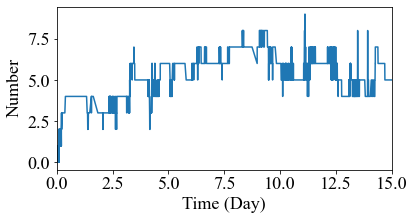

In [47]:
font = {
    "family": "Times New Roman",
    'size': 18
}

matplotlib.rc('font', **font)
_, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_runtime['timestamp'], df_runtime['max_rack_usage'])
ax.set_xlim(0, 15)
ax.set_xlabel("Time (Day)")
ax.set_ylabel("Number")

Text(0, 0.5, 'Number')

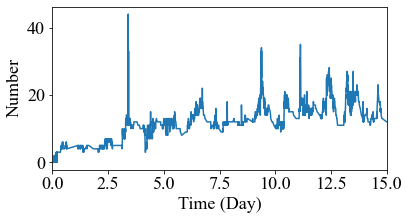

In [48]:
_, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_runtime['timestamp'], df_runtime['num_contention_jobs'])
ax.set_xlim(0, 15)
ax.set_xlabel("Time (Day)")
ax.set_ylabel("Number")

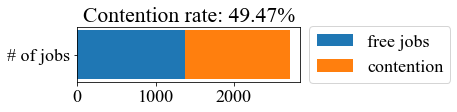

In [53]:
_, ax = plt.subplots(figsize=(4, 1))
num_jobs = len(df_worker_jobs)
num_contention_jobs = len(contention_jobs)
num_free_jobs = num_jobs - num_contention_jobs
ax.barh([0], num_free_jobs, label="free jobs")
ax.barh([0], num_contention_jobs, left=num_free_jobs, label="contention")

ax.set_yticks([0], labels=["# of jobs"])
ax.set_title(f"Contention rate: {num_contention_jobs/num_jobs*100:.2f}%")

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))